# **Brain Tumor Segmentation Using UNet Model**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [5]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import (
Input,
Conv2D,
MaxPooling2D,
Dropout,
Conv2DTranspose,
Concatenate

)

In [6]:
from glob import glob
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Set the root directory of the dataset
base_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"  

# Get list of all patient folders
patient_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

image_paths = []
mask_paths = []

for patient_dir in patient_dirs:
    # Get all .tif files in this patient folder
    tif_files = glob(os.path.join(patient_dir, "*.tif"))
    
    # Separate images and masks
    for file in tif_files:
        if "_mask" in os.path.basename(file):
            mask_paths.append(file)
        else:
            image_paths.append(file)

# Optional: sort both lists to ensure they match
image_paths.sort()
mask_paths.sort()

# Check counts
print(f"Total images: {len(image_paths)}")
print(f"Total masks: {len(mask_paths)}")

# Check a few matched pairs
for img, mask in zip(image_paths[:3], mask_paths[:3]):
    print(f"Image: {img}  ->  Mask: {mask}")

Total images: 3929
Total masks: 3929
Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  ->  Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  ->  Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  ->  Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif


/tmp/ipykernel_35/1003790755.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_paths[N])
/tmp/ipykernel_35/1003790755.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_paths[N])


Text(0.5, 1.0, 'Segmentation')

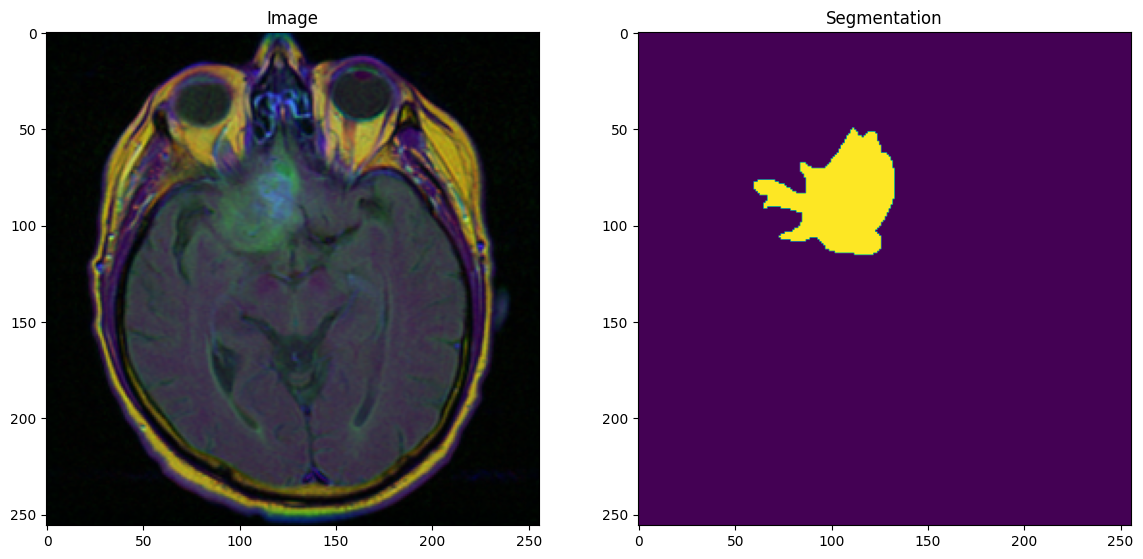

In [8]:
N = 2
img = imageio.imread(image_paths[N])
mask = imageio.imread(mask_paths[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [9]:
image_list_ds = tf.data.Dataset.list_files(image_paths, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_paths, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

I0000 00:00:1748944549.933101      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'>)


In [10]:
image_filenames=tf.constant(image_paths)
masks_filenames=tf.constant(mask_paths)

dataset=tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif', shape=(), dtype=string)


In [11]:
pip install tensorflow-io


Note: you may need to restart the kernel to use updated packages.


In [25]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    return image, mask

# Assuming image_paths and mask_paths are lists of file paths
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

def preprocess(image, mask):
    # e.g., resizing to 128x128
    image = tf.image.resize(image, [96, 128])
    mask = tf.image.resize(mask, [96, 128])
    return image, mask

dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [24]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)


In [26]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  (3, 3),   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  (3, 3),   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [32]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    from tensorflow.keras.layers import Concatenate

    merge = Concatenate(axis=-1)([up, contractive_input])

    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 (3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [33]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [34]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [35]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 96, 128, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 96, 128, 32)    │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 96, 128, 32)    │          9,248 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 48, 64, 32)     │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 48, 64, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 48, 64, 64)     │         36,928 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 24, 32, 64)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 24, 32, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 24, 32, 128)    │        147,584 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 12, 16, 128)    │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 12, 16, 256)    │        295,168 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 12, 16, 256)    │        590,080 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 12, 16, 256)    │              0 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 6, 8, 256)      │              0 │ dropout_4[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 6, 8, 512)      │      1,180,160 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 6, 8, 512)      │      2,359,808 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 6, 8, 512)      │              0 │ conv2d_29[0][0]        │
├──────────────────────

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
unet.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [38]:
EPOCHS = 20
BATCH_SIZE=16
history = unet.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Epoch 1/20


I0000 00:00:1748945428.675787     103 service.cc:148] XLA service 0x7864040021f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748945428.676323     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748945429.693081     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4655 - loss: 1.1889   

I0000 00:00:1748945438.576546     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/221 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.9651 - loss: 0.3023 - val_accuracy: 0.9896 - val_loss: 0.0334
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9895 - loss: 0.0324 - val_accuracy: 0.9914 - val_loss: 0.0284
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9917 - loss: 0.0255 - val_accuracy: 0.9921 - val_loss: 0.0283
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9917 - loss: 0.0237 - val_accuracy: 0.9919 - val_loss: 0.0240
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9924 - loss: 0.0208 - val_accuracy: 0.9926 - val_loss: 0.0210
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9923 - loss: 0.0206 - val_accuracy: 0.9925 - val_loss: 0.0214
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9924 - loss: 0.0195 - val_accuracy: 0.9925 - val_loss: 0.0222
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9924 - loss: 0.0195 - val_accuracy: 0.9

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step


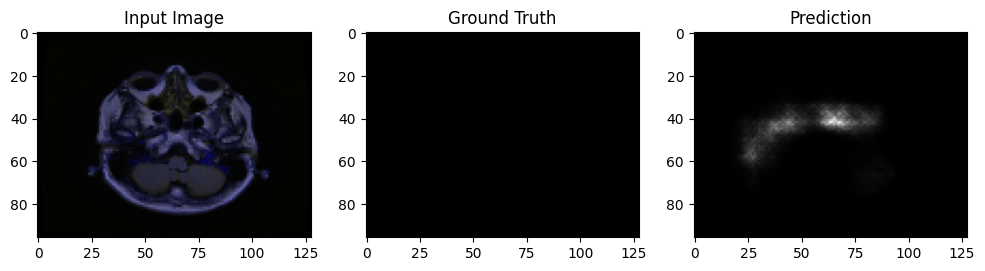

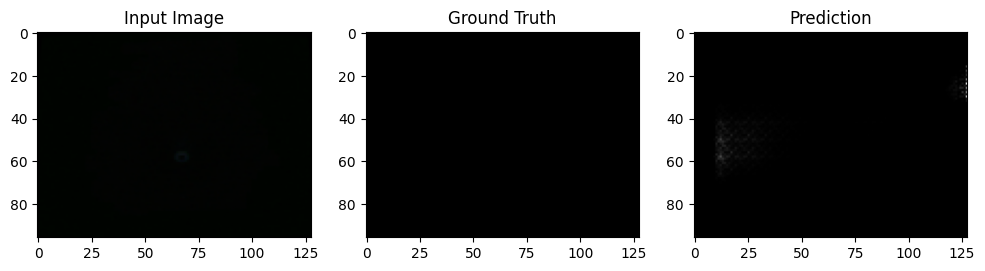

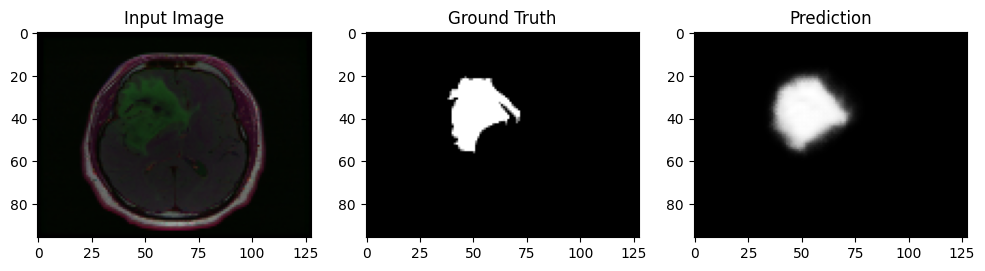

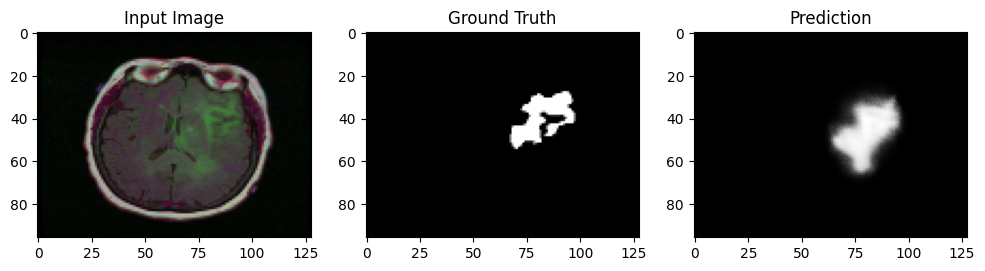

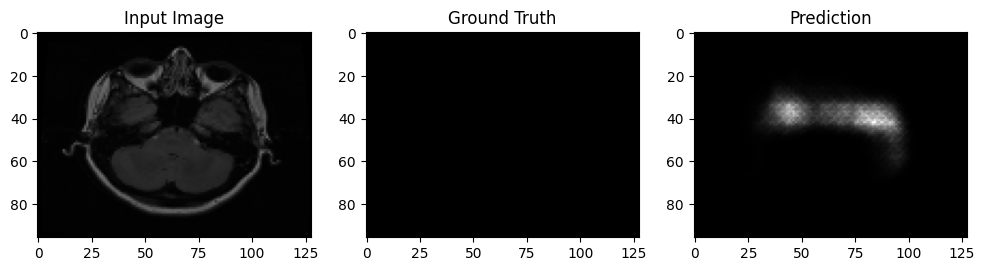

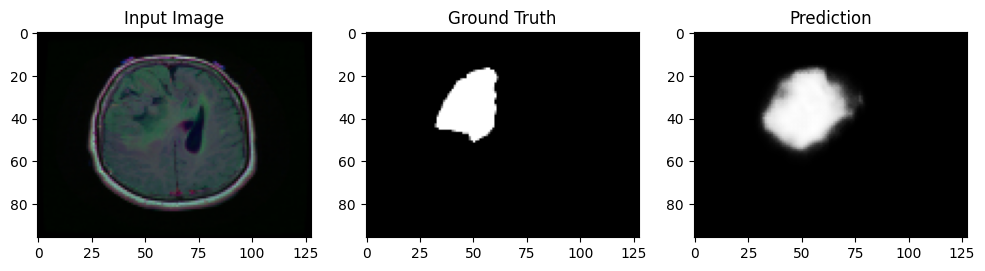

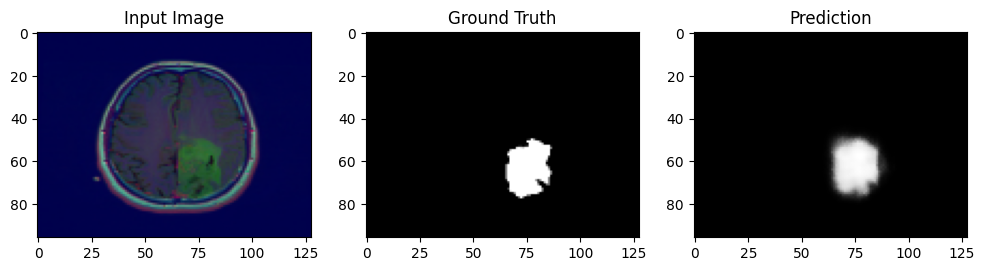

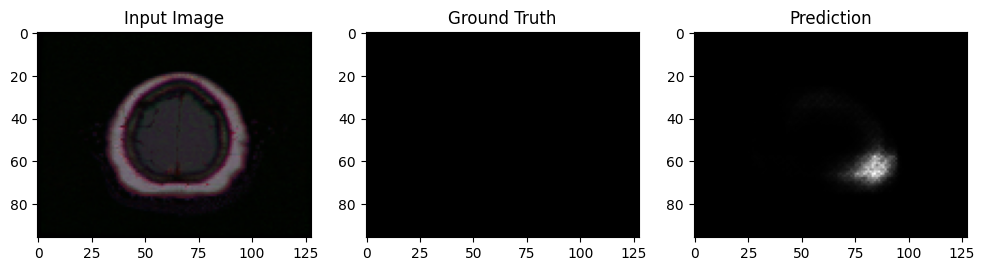

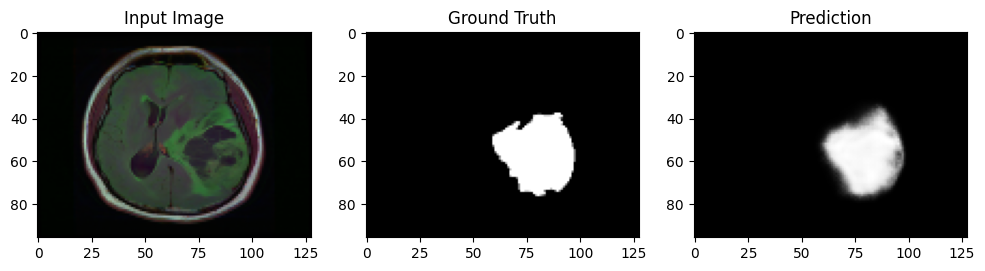

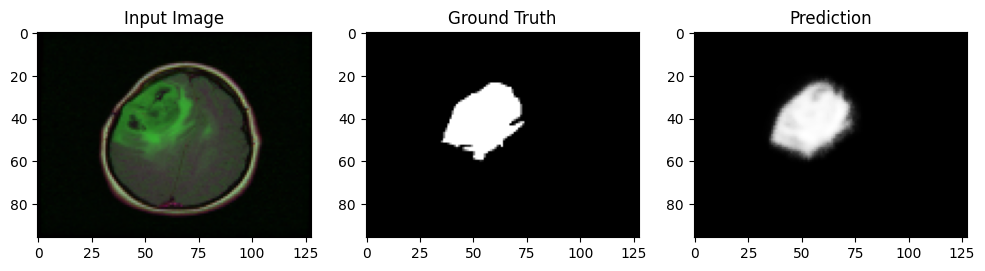

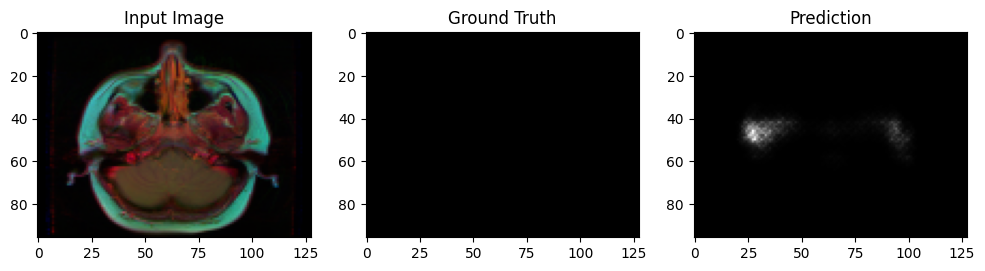

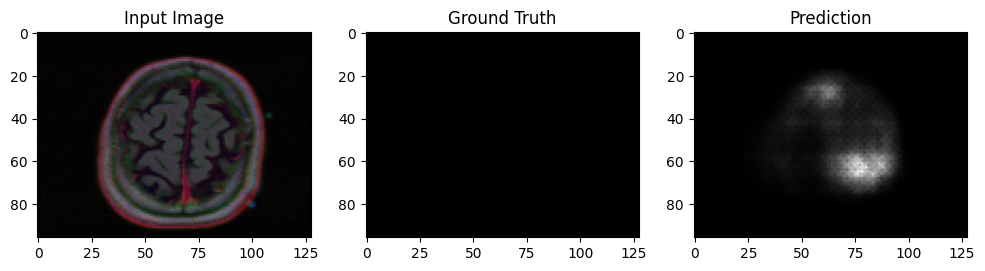

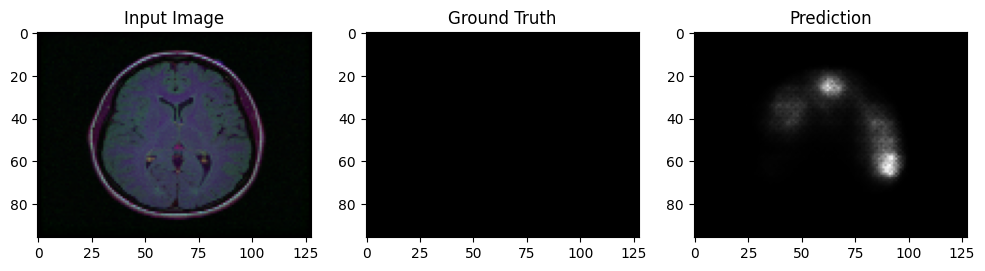

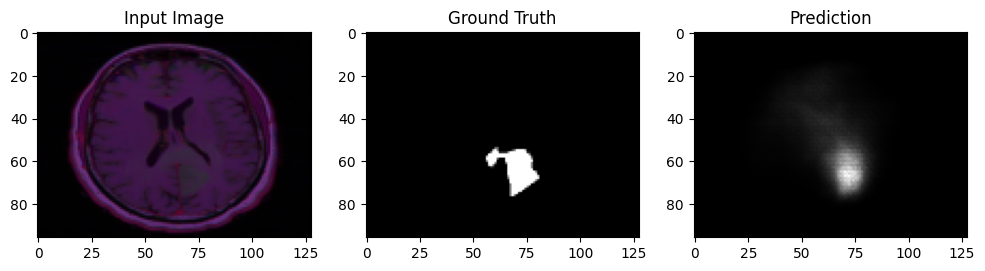

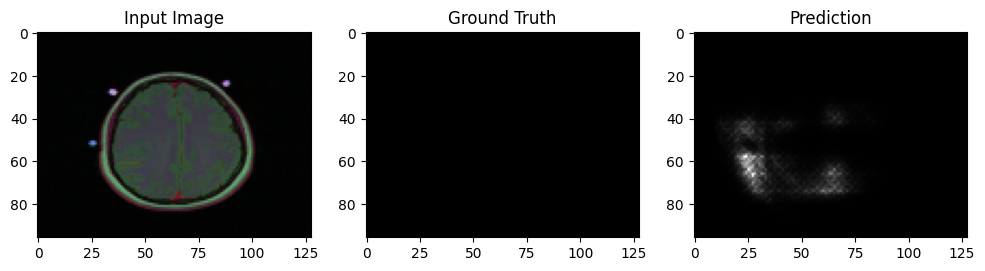

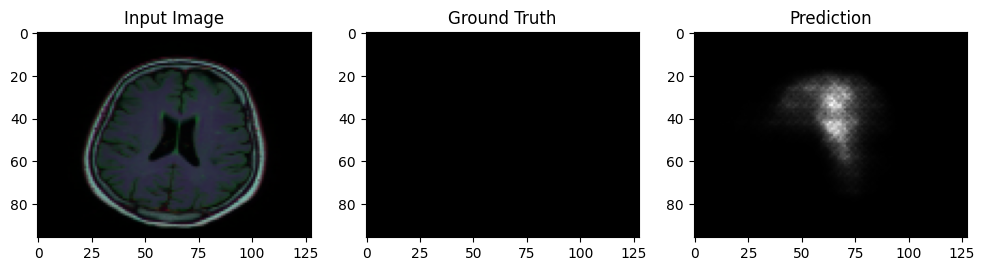

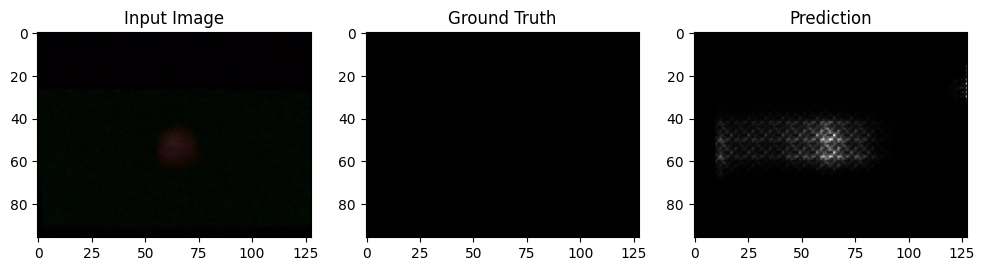

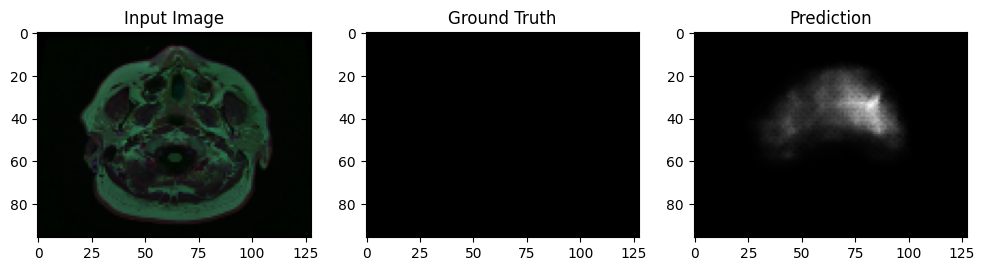

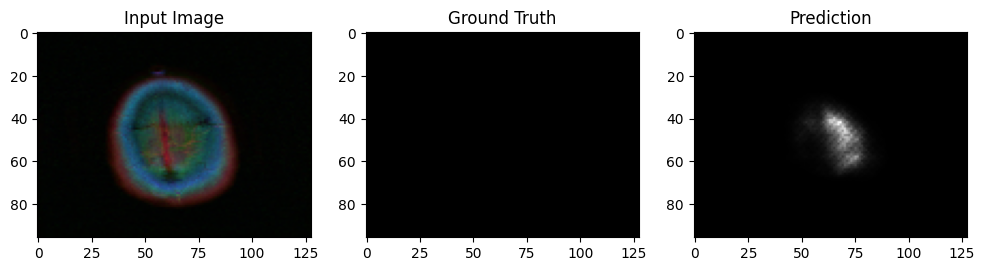

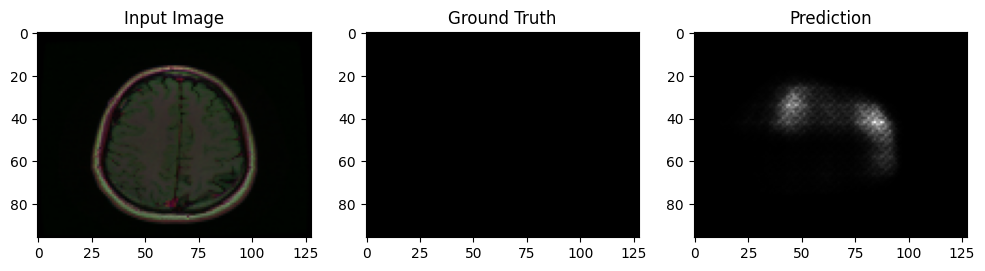

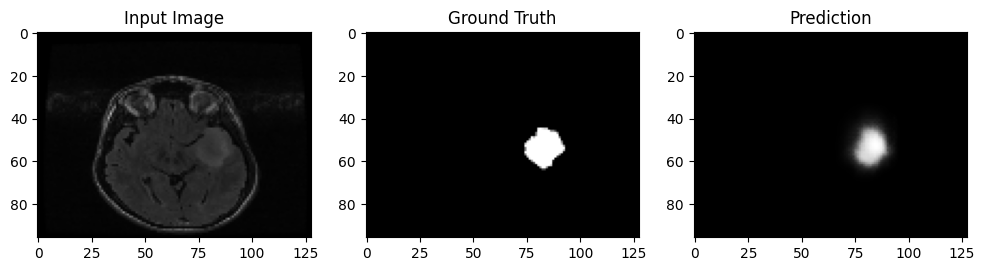

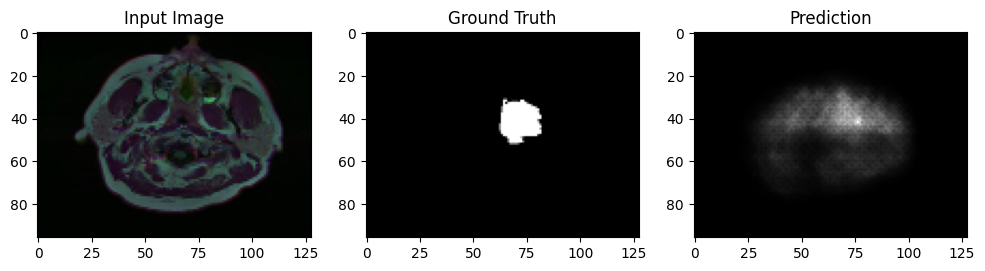

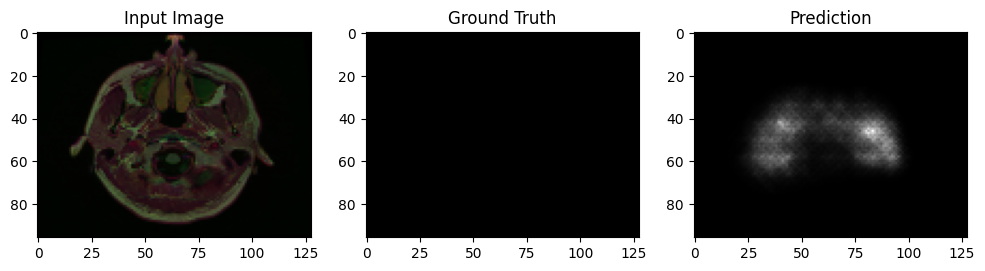

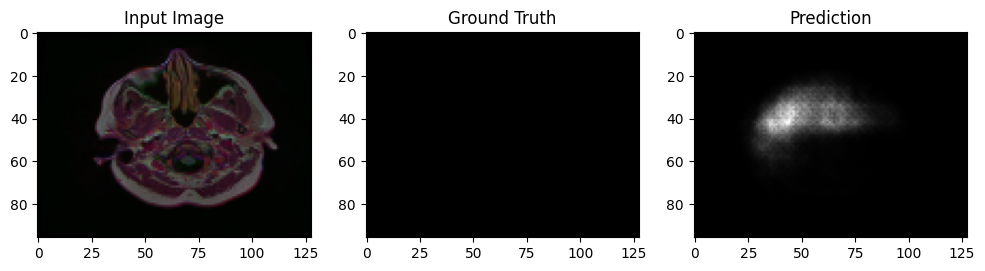

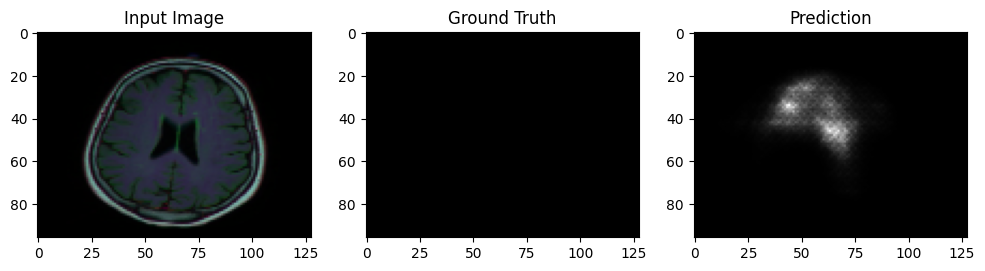

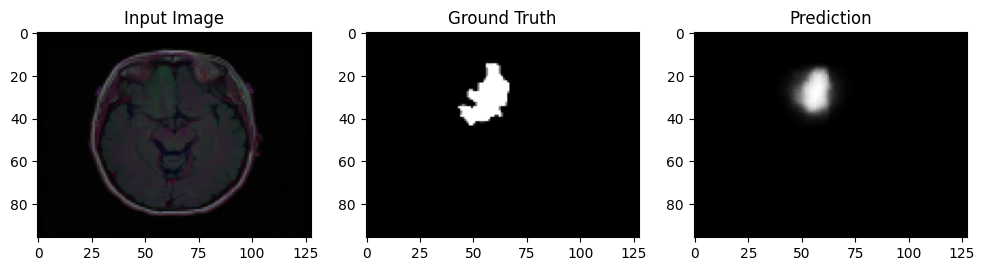

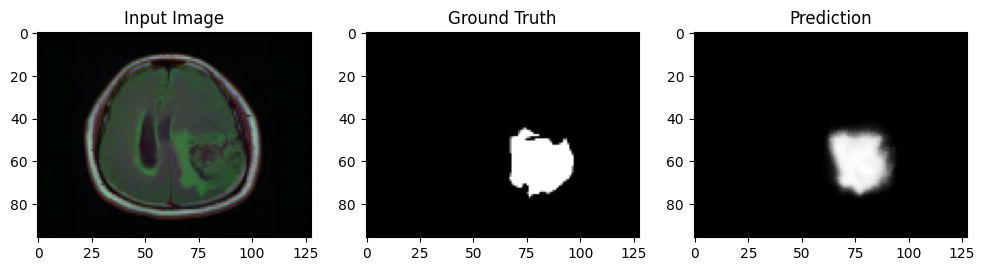

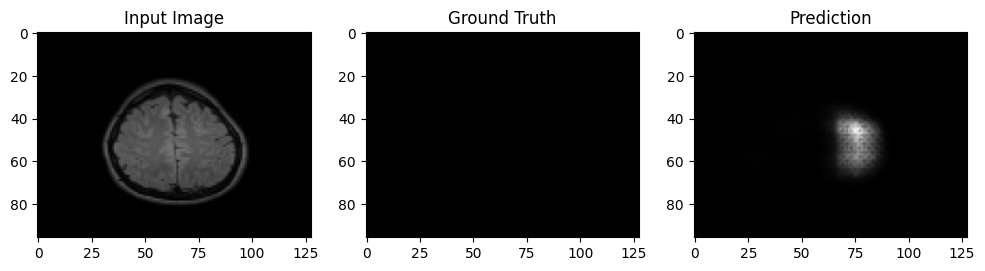

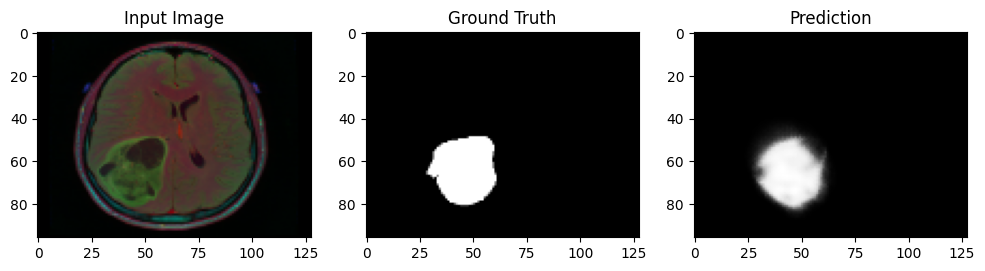

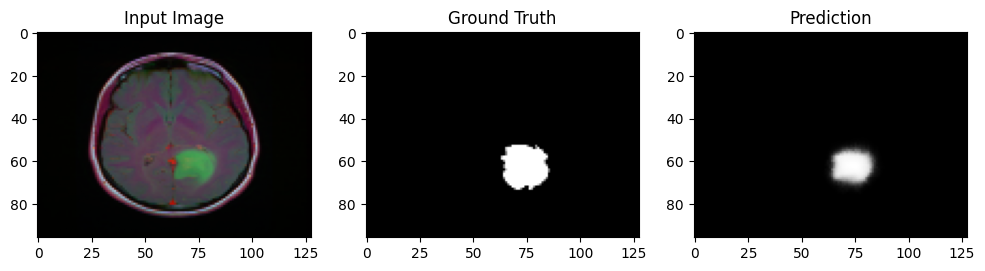

In [39]:
def plot_sample(image, ground_truth, prediction):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.show()

# Predict and visualize a few examples
preds = unet.predict(x_val)

for i in range(30):
    plot_sample(x_val[i], y_val[i], preds[i])
